# OSM Econ Week 6: Lucas Model
## Rebekah Dix

In [1]:
# import statements
import pandas as pd
import numpy as np
import scipy.optimize as opt
import matplotlib.pyplot as plt
from functools import reduce
from functools import partial
%matplotlib inline

In [2]:
# Import and clean data
headers = ['date', 'w5000']
w5000 = pd.read_csv('data/WILL5000INDFC.csv', header=None, names=headers, skiprows=1)
w5000['date'] = pd.to_datetime(w5000['date'])
w5000.set_index('date', inplace=True)
w5000['w5000'] = pd.to_numeric(w5000['w5000'], errors='coerce')

pce = pd.read_csv('data/PCECC96.csv')
pce.columns = ['date', 'pce']
pce.set_index('date', inplace=True)
pce['pce'] = pd.to_numeric(pce['pce'], errors='coerce')

gdpdef = pd.read_csv('data/GDPDEF.csv')
gdpdef.columns = ['date', 'gdp_deflate']
gdpdef.set_index('date', inplace=True)
gdpdef['gdp_deflate'] = pd.to_numeric(gdpdef['gdp_deflate'], errors='coerce')

headers = ['date', 'tb3m']
tb3m = pd.read_csv('data/TB3MS.csv', header=None, names=headers, skiprows=1)
tb3m['date'] = pd.to_datetime(tb3m['date'])
tb3m.set_index('date', inplace=True)
tb3m['tb3m'] = pd.to_numeric(tb3m['tb3m'], errors='coerce')

In [3]:
# Resample to make data quarterly 
w5000 = w5000.resample('D').asfreq()
w5000 = w5000.fillna(method='ffill')
w5000 = w5000.resample('Q').asfreq()
tb3m = tb3m.resample('D').asfreq()
tb3m = tb3m.fillna(method='ffill')
tb3m = tb3m.resample('Q').asfreq()
w5000.index = w5000.index + pd.DateOffset(1)
tb3m.index = tb3m.index + pd.DateOffset(1)

In [4]:
# Merge all data into one dataframe
dfs = [w5000, pce, gdpdef, tb3m]
df = reduce(lambda df1, df2: df1.merge(df2, "outer", left_index=True, right_index=True), dfs)
df = df.dropna(axis=0)
df['w5000_r'] = df['w5000'] / (df['gdp_deflate'] / 100)
df['w5000_r_return'] = df['w5000_r'] / df['w5000_r'].shift(1)
df['tb3m'] = df['tb3m']/100 + 1
df.head()

,w5000,pce,gdp_deflate,tb3m,w5000_r,w5000_r_return
date,,,,,,
1971-04-01,1.12,2996.124,23.846,1.0338,4.696804,NaN
1971-07-01,1.13,3020.036,24.088,1.0475,4.691133,0.998792
1971-10-01,1.12,3070.230,24.288,1.0469,4.611331,0.982989
1972-01-01,1.18,3110.801,24.664,1.0401,4.784301,1.037510
1972-04-01,1.26,3170.159,24.815,1.0373,5.077574,1.061299


# Problem 1

In [5]:
class GMMEstimate_1(object):
    """
    This class defines a GMM estimator for γ in a simple asset pricing model.
    
    Attributes:
        df (dataframe) : contains consumption, returns data
        beta (scalar) : discount factor
    
    """
    
    def __init__(self, df, beta):
        
        self.df = df
        self.beta = beta
    
    def objective(self, gamma):
        mu = self.df.pce ** (-gamma)
        m = self.beta * mu / mu.shift(1)
        R = self.df.w5000_r_return
        m  = m[1:]
        R = R[1:]
        cov = np.cov(m, R)[0, 1]
        obj = (1 - cov - m.mean() * R.mean())
        
        return obj
        
    def estimate(self, guess):
        gamma = opt.broyden1(self.objective, guess)
        return gamma
        

In [6]:
problem1 = GMMEstimate_1(df, .99)

In [7]:
problem1.estimate(1)

array(1.35084241)

# Problem 2

A CRRA parameter of 1.35 doesn't seem unreasonable. We can compare with previous literature to see if our estimates are similar. This recent FED working paper (https://files.stlouisfed.org/files/htdocs/wp/2014/2014-005.pdf) estimates gamma to be 1.39. We're very close!

# Problem 3

In [8]:
class GMMEstimate_2(object):
    """
    This class defines a GMM estimator for γ in a simple asset pricing model.
    
    Attributes:
        df (dataframe) : contains consumption, returns data
        beta (scalar) : discount factor
    
    """
    
    def __init__(self, df, beta):
        
        self.df = df
        self.beta = beta
    
    def objective(self, gamma):
        mu = self.df.pce ** (-gamma)
        m = self.beta * mu / mu.shift(1)
        m  = m[1:]
        rp1 = self.df.tb3m[1:]
        err = rp1 - 1 / np.mean(m) 
        obj = np.sum(err ** 2)

        return obj
        
    def estimate(self, guess):
        gamma = opt.minimize(self.objective, guess, method='Nelder-Mead')
        return gamma
        

In [9]:
problem3 = GMMEstimate_2(df, .99)

In [10]:
problem3.estimate(1)

 final_simplex: (array([[4.91972656],
       [4.91962891]]), array([0.22433773, 0.22433773]))
           fun: 0.22433772994668466
       message: 'Optimization terminated successfully.'
          nfev: 40
           nit: 20
        status: 0
       success: True
             x: array([4.91972656])

I couldn't get the minimization problem to converge using the Broyden method. However, switching methods, I find that $\gamma = 4.9$ under this estimation procedure. This is a very different (much, much larger) estimate from our first attempt.

# Problem 4

In [11]:
class GMMEstimate_3(object):
    """
    This class defines a GMM estimator for γ in a simple asset pricing model.
    
    Attributes:
        df (dataframe) : contains consumption, returns data
    
    """
    
    def __init__(self, df):
        
        self.df = df
    
    def objective(self, vec):
        
        # Unpack parameters to estimate
        gamma, beta = vec

        # Define moments and weight matrix
        moms = np.empty(2)
        W = np.eye(2)
        
        # Calculate moment one (equation 5)
        mu = self.df.pce ** (-gamma)
        m = beta * mu / mu.shift(1)
        R = self.df.w5000_r_return
        m  = m[1:]
        R = R[1:]
        
        cov = np.cov(m, R)[0, 1]
        moms[0] = (1 - cov - m.mean() * R.mean())
            
        # Calculate moment two (equation 7)
        rp1 = self.df.tb3m[1:]
        err = rp1 - 1 / np.mean(m) 
        moms[1] = np.sum(err ** 2)
        
        # Calculate error
        err = moms.T @ W @ moms
        
        return err
        
    def estimate(self, guess):
        params = opt.minimize(self.objective, guess, method='L-BFGS-B', 
                             bounds=((1e-3, None), (1e-3, 1)))
        return params
        

In [12]:
problem4 = GMMEstimate_3(df)

In [13]:
problem4.estimate([2, 1])

      fun: 0.05099074142283638
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([9.23358612e-06, 4.23966418e-07])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 24
      nit: 4
   status: 0
  success: True
        x: array([2.00232847, 0.96939664])

In [14]:
n = 60
N = 5
gamma_grid = np.linspace(1.9, 2.1, n)
beta_grid = np.linspace(0.95, 0.99, N)

estimates = np.empty((n, N))
for ii in range(n):
    for jj in range(N):
        res = problem4.estimate([gamma_grid[ii], beta_grid[jj]])
        estimates[ii, jj] = res.fun

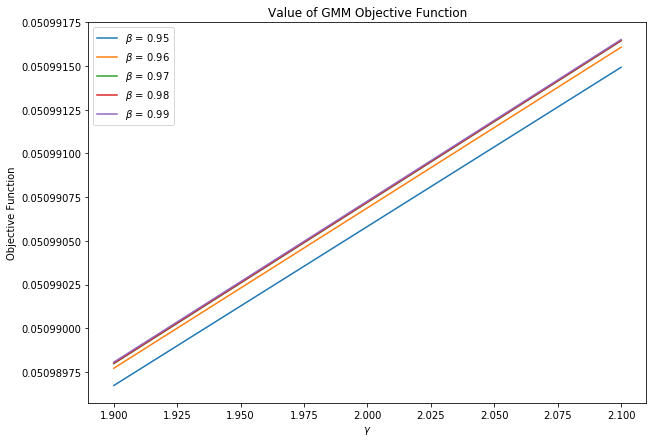

In [15]:
plt.figure(figsize=(10, 7))
for jj in range(N):
    plt.plot(gamma_grid, estimates[:, jj], label=rf'$\beta$ = {beta_grid[jj]:.2f}')
plt.title('Value of GMM Objective Function')
plt.xlabel('$\gamma$')
plt.ylabel('Objective Function')
plt.legend()
plt.show()

In this problem, we are estimating both parameters simultaneously. In this way, we're using more data at once, but we may have more troubles with convergence etc.